# Previsão da probabilidade de inadimplência

Este notebook tem como objetivo aplicar o modelo final treinado para estimar a probabilidade de inadimplência na base de dados que não possui a variável alvo. Nele, o modelo salvo é carregado, os dados inéditos passam pelos mesmos passos de pré-processamento utilizados no treinamento, e em seguida são geradas as previsões de probabilidade. Por fim, os resultados são exportados para uso posterior. Vale lembrar que este notebook é voltado apenas para a etapa de inferência, ou seja, não realiza nenhum tipo de re-treinamento do modelo. **É necessário executar os notebooks anteriores para chegar até aqui**.


In [110]:
import pickle
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

## Pré-processamento

In [111]:
# Leitura do dataset
test_features_v1 = pd.read_csv('../data/processed/test_features_v1.csv')

# Conversão dos tipos numéricos e categóricos
test_features_v1 = test_features_v1.astype({
    'ID_CLIENTE': 'int64',
    'VALOR_A_PAGAR': 'float64',
    'TAXA': 'float64',
    'RENDA_MES_ANTERIOR': 'float64',
    'NO_FUNCIONARIOS': 'int64',
    'FLAG_PF': 'int64',
    'TEMPO_DE_CASA_MESES': 'int64',
    'PRAZO_PAGAMENTO_DIAS': 'int64',
    'MES_SAFRA': 'int32',
    'INADIMPLENCIAS_ANTERIORES': 'int64',
    'SEGMENTO_INDUSTRIAL': 'category',
    'DOMINIO_EMAIL': 'category',
    'PORTE': 'category',
    'CEP_2_DIG': 'category',
})

# Conversão de datas
test_features_v1['SAFRA_REF'] = pd.to_datetime(
    test_features_v1['SAFRA_REF'], format='%Y-%m-%d', errors='coerce'
)

test_features_v1['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(
    test_features_v1['DATA_EMISSAO_DOCUMENTO'], format='%Y-%m-%d', errors='coerce'
)

test_features_v1['DATA_VENCIMENTO'] = pd.to_datetime(
    test_features_v1['DATA_VENCIMENTO'], format='%Y-%m-%d', errors='coerce'
)

test_features_v1['DATA_CADASTRO'] = pd.to_datetime(
    test_features_v1['DATA_CADASTRO'], format='%Y-%m-%d', errors='coerce'
)

# Eliminar colunas irrelevantes
cols_drop = [
    'ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 
    'DATA_VENCIMENTO', 'DATA_CADASTRO', 'SAFRA_REF',
]

df = test_features_v1.drop(columns=cols_drop)


# Aplicando One-Hot Encoding em variáveis categóricas de baixa cardinalidade
df = pd.get_dummies(df, columns=['SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL'], drop_first=True)

# Aplicando Frequency Encoding para variável com alta cardinalidade 
freq_map = df['CEP_2_DIG'].value_counts(normalize=True)
df['CEP_2_DIG'] = df['CEP_2_DIG'].map(freq_map)

# Importante não adionar a variável target, resultaria em data leackage e consequentemente overfitting
X_new = df

In [112]:
X_new

,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF,CEP_2_DIG,TEMPO_DE_CASA_MESES,PRAZO_PAGAMENTO_DIAS,MES_SAFRA,INADIMPLENCIAS_ANTERIORES,ADIANTAMENTOS_ANTERIORES,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,PORTE_MEDIO,PORTE_PEQUENO,DOMINIO_EMAIL_HOTMAIL,DOMINIO_EMAIL_OUTROS,DOMINIO_EMAIL_YAHOO
0,138986.90,5.99,384807.0,124,0,0.010029,126,18,7,1,5,False,False,False,True,True,False,False
1,62641.90,5.99,384807.0,124,0,0.010029,127,18,7,1,5,False,False,False,True,True,False,False
2,116033.85,8.99,384807.0,124,0,0.010029,127,16,7,1,5,False,False,False,True,True,False,False
3,45597.80,8.99,103248.0,119,0,0.010029,127,16,8,1,5,False,False,False,True,True,False,False
4,46317.75,8.99,103248.0,119,0,0.010029,128,18,8,1,5,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12259,88179.95,11.99,856312.0,107,0,0.002446,198,17,11,2,12,False,True,True,False,True,False,False
12260,27301.65,11.99,856312.0,107,0,0.002446,198,18,11,2,12,False,True,True,False,True,False,False
12261,29051.65,11.99,856312.0,107,0,0.002446,198,16,11,2,12,False,True,True,False,True,False,False
12262,110061.00,4.99,856312.0,107,0,0.002446,198,17,11,2,12,False,True,True,False,True,False,False


## Predição de inadimplência

In [113]:
# Carregar o conteúdo
with open('../data/processed/final_random_forest_structure.pkl', 'rb') as f:
    modelo = pickle.load(f)

Prevendo a probabilidade de inadimplência 

In [114]:
y_proba = modelo.predict_proba(X_new)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.0s finished


 Os resultados mostram que a maioria dos clientes tem baixo risco de inadimplência, com média de probabilidade em torno de 15%. O desvio padrão de 0.18 indica que o modelo consegue diferenciar bem os perfis de risco. As probabilidades variam de quase 0% até 99%, o que mostra boa capacidade de discriminação do modelo

In [115]:
print("Média das probabilidades:", np.mean(y_proba[:, 1]))
print("Desvio padrão das probabilidades:", np.std(y_proba[:, 1]))
print("Probabilidade mínima:", np.min(y_proba[:, 1]))
print("Probabilidade máxima:", np.max(y_proba[:, 1]))

Média das probabilidades: 0.15226211837491668
Desvio padrão das probabilidades: 0.18180665868440177
Probabilidade mínima: 1.9391179990076762e-05
Probabilidade máxima: 0.9897678925698365


In [116]:
y_proba[:, 1]

array([0.05308097, 0.06429701, 0.06165298, ..., 0.08072774, 0.06931608,
       0.07203898])

Construindo tabela da maneira como o enunciado do case pede

In [117]:
submissao_case = test_features_v1[['ID_CLIENTE', 'SAFRA_REF']].copy()

submissao_case['PROBABILIDADE_INADIMPLENCIA'] = y_proba[:, 1]

In [118]:
submissao_case

,ID_CLIENTE,SAFRA_REF,PROBABILIDADE_INADIMPLENCIA
0,8784237149961904,2021-07-01,0.053081
1,8784237149961904,2021-07-01,0.064297
2,8784237149961904,2021-07-01,0.061653
3,8784237149961904,2021-08-01,0.042645
4,8784237149961904,2021-08-01,0.061905
...,...,...,...
12259,9206030810342980458,2021-11-01,0.094078
12260,9206030810342980458,2021-11-01,0.110089
12261,9206030810342980458,2021-11-01,0.080728
12262,9206030810342980458,2021-11-01,0.069316


Ordenando os registros de acordo com a base_pagamentos_teste

In [119]:
base_pagamentos_teste = pd.read_csv('../data/raw/base_pagamentos_teste.csv', sep=';')

base_pagamentos_teste.head(5)

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99


In [120]:
submissao_case_ord = submissao_case.set_index(['ID_CLIENTE', 'SAFRA_REF'])
original_or = base_pagamentos_teste.set_index(['ID_CLIENTE', 'SAFRA_REF'])
submissao_case = submissao_case_ord.loc[original_or.index].reset_index()

Ajustando a data para da safra para o formato original 

In [121]:
submissao_case['SAFRA_REF'] = pd.to_datetime(submissao_case['SAFRA_REF']).dt.to_period('M').astype(str)

In [122]:
submissao_case.head(5)

,ID_CLIENTE,SAFRA_REF,PROBABILIDADE_INADIMPLENCIA
0,5058298901476893676,2021-07,0.024558
1,5058298901476893676,2021-07,0.027131
2,5058298901476893676,2021-07,0.029143
3,5058298901476893676,2021-07,0.027131
4,274692171162531764,2021-07,0.006968


Visualizando os dados 

Este gráfico mostra a distribuição das probabilidades de inadimplência previstas pelo modelo.
A maioria dos casos recebeu probabilidades baixas (próximas de zero), indicando que o modelo considera a maior parte dos clientes como baixo risco. Poucos casos aparecem com probabilidade alta, o que é esperado em bases desbalanceadas.


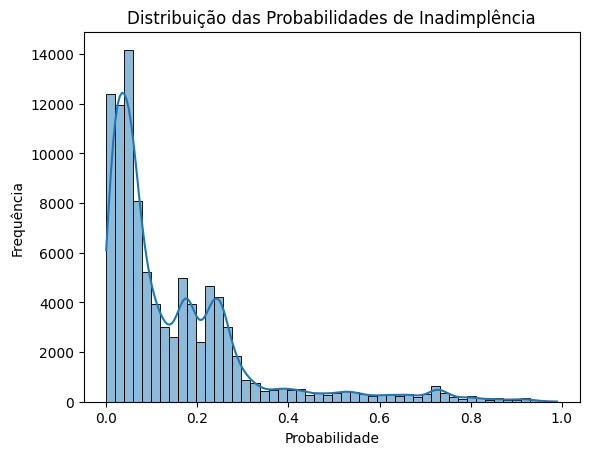

In [123]:
sns.histplot(submissao_case['PROBABILIDADE_INADIMPLENCIA'], bins=50, kde=True)
plt.title('Distribuição das Probabilidades de Inadimplência')
plt.xlabel('Probabilidade')
plt.ylabel('Frequência')
plt.show()

Este gráfico mostra que apenas 5,6% dos registros possuem probabilidade de inadimplência igual ou superior a 50%, segundo o modelo.
Ou seja, a grande maioria (94,4%) foi classificada como baixo risco, reforçando o desbalanceamento natural do problema.

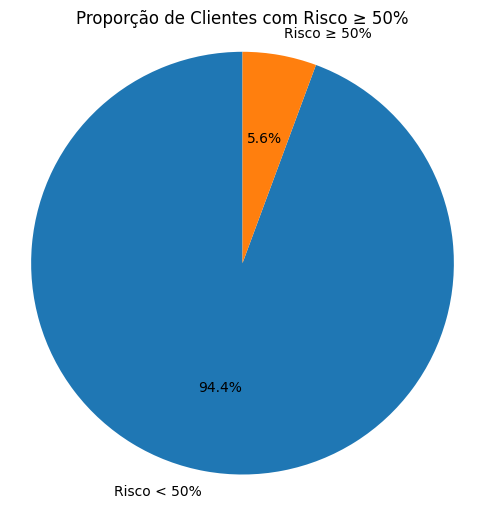

In [124]:
# Filtro para clientes com probabilidade >= 0.5
alto_risco = submissao_case['PROBABILIDADE_INADIMPLENCIA'] >= 0.5

# Contagens
n_alto_risco = alto_risco.sum()
n_baixo_risco = len(submissao_case) - n_alto_risco

# Dados para o gráfico
labels = ['Risco < 50%', 'Risco ≥ 50%']
sizes = [n_baixo_risco, n_alto_risco]

# Gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=90)
plt.title('Proporção de Clientes com Risco ≥ 50%')
plt.axis('equal')
plt.show()

In [125]:
submissao_case.to_csv('../data/processed/submissao_case.csv', index=False)